In [20]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import urllib.request
from app.utils.dataset import DepthDataset, create_data_loader
from app.utils.env import Env
import matplotlib.pyplot as plt
import cv2

In [21]:
env = Env()

In [50]:

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

dataloader = create_data_loader(
    dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

In [51]:
raw_image, depth_image = dataset[0]

In [68]:
raw_np = np.array(raw_image)

In [53]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\mkami/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [54]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


In [69]:
raw_np.shape

(256, 256, 3)

In [78]:
input_tensor = transform(raw_np).to(device)

In [79]:
input_tensor.shape

torch.Size([1, 3, 256, 256])

In [80]:
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=raw_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()
    

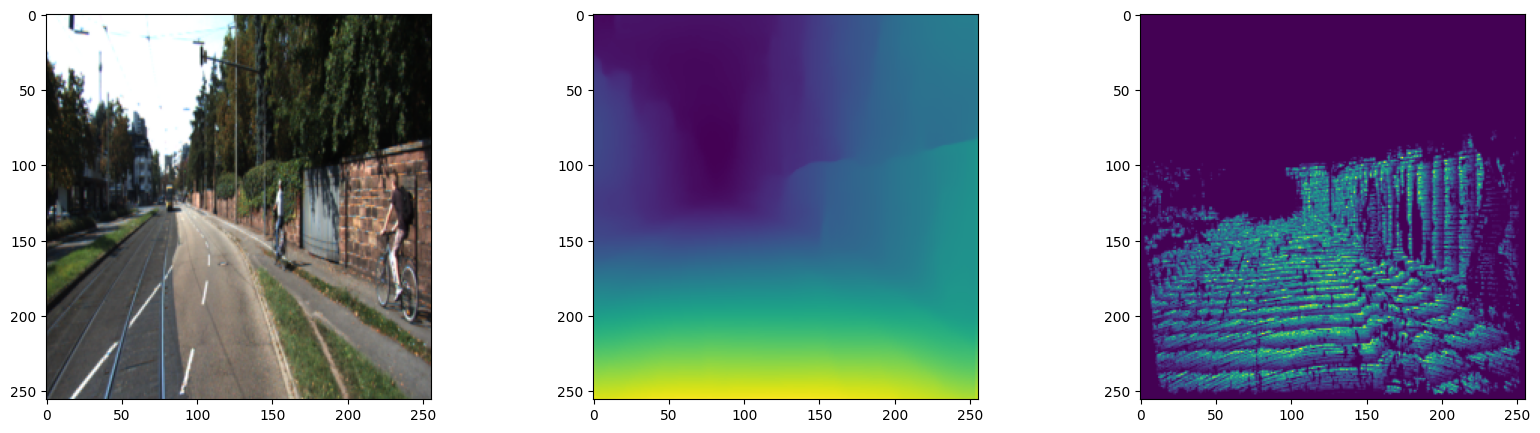

In [93]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(raw_np)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(prediction)

ax = fig.add_subplot(1, 3,3)
ax.imshow(depth_image.permute(1,2,0).numpy() * 255)

In [ ]:
def scale_depth(pred, gt, mask):
    scale = np.median(gt[mask]) / np.median(pred[mask])
    return pred * scale

pred_aligned = scale_depth(prediction, gt_depth, valid_mask)


def compute_metrics(gt, pred, mask):
    thresh = np.maximum(gt[mask] / pred[mask], pred[mask] / gt[mask])
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt[mask] - pred[mask]) / gt[mask])
    rmse = np.sqrt(np.mean((gt[mask] - pred[mask]) ** 2))
    log10 = np.mean(np.abs(np.log10(gt[mask]) - np.log10(pred[mask])))

    return {
        "AbsRel": abs_rel,
        "RMSE": rmse,
        "Log10": log10,
        "δ < 1.25": a1,
        "δ < 1.25^2": a2,
        "δ < 1.25^3": a3
    }

metrics = compute_metrics(gt_depth, pred_aligned, valid_mask)
print("Depth Estimation Metrics on KITTI:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}")


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_depth, cmap="plasma", vmin=0, vmax=80)
plt.title("Ground Truth Depth")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(pred_aligned, cmap="plasma", vmin=0, vmax=80)
plt.title("MiDaS_small Prediction (scaled)")
plt.colorbar()

plt.tight_layout()
plt.show()
